In [68]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [69]:
# Define the SP500 tickers and sector index ticker
sp500_tickers = ['AAPL', 'MSFT', 'GOOGL']  # Example tickers
sector_index_ticker = 'XLC'  # Example sector index ticker for Technology

# Fetch historical data for these tickers and the sector index
def fetch_data(tickers, start_date, end_date):
    data = {}
    for ticker in tickers:
        data[ticker] = yf.download(ticker, start=start_date, end=end_date)
    return data

data = fetch_data(sp500_tickers, '2004-08-12', '2024-08-12')


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [48]:

# Fetch the sector index data
sector_index_data = yf.download(sector_index_ticker, start='2004-08-12', end='2024-08-12')

def fetch_company_info(ticker):
    company = yf.Ticker(ticker)
    return company.info


[*********************100%%**********************]  1 of 1 completed


In [70]:
def calculate_metrics(info):
    metrics = {
        'P/E Ratio': info.get('forwardEps') / info.get('previousClose') if info.get('forwardEps') and info.get('previousClose') else None,
        # 'EPS': info.get('earningsPerShare'),
        'P/B Ratio': info.get('priceToBook'),
        'Dividend Yield': info.get('dividendYield'),
        'Dividend Payout Ratio': info.get('payoutRatio'),
        'ROE': info.get('returnOnEquity'),
        'ROA': info.get('returnOnAssets'),
        # 'ROI': info.get('returnOnInvestment'),
        'Beta': info.get('beta'),
        'Market Capitalization': info.get('marketCap'),
        'Revenue Growth': info.get('revenueGrowth'),
        # 'Net Profit Margin': info.get('netProfitMargin'),
        # 'Gross Profit Margin': info.get('grossProfitMargin'),
        # 'Operating Margin': info.get('operatingMargin'),
        'Debt-to-Equity Ratio': info.get('debtToEquity'),
        'Free Cash Flow': info.get('freeCashflow'),
        'Current Ratio': info.get('currentRatio'),
        'Quick Ratio': info.get('quickRatio'),
        # 'Interest Coverage Ratio': info.get('interestCoverageRatio'),
        # 'P/S Ratio': info.get('priceToSales'),
        'PEG Ratio': info.get('pegRatio'),
        # Additional metrics
        # 'Alpha': None,
        'Standard Deviation': None,
        'Value at Risk (VaR)': None,
        'Sharpe Ratio': None,
        'Sortino Ratio': None,
        'Maximum Drawdown': None,
        'Downside Deviation': None,
        'Tracking Error': None,
        'R-squared': None,
        'Treynor Ratio': None,
        'Information Ratio': None,
        'Conditional Value at Risk (CVaR)': None,
        'Beta-adjusted Sharpe Ratio': None,
        'Drawdown Duration': None,
        'Ulcer Index': None,
        'Jensen’s Alpha': None
    }
    return metrics


In [71]:

# Ensure company_data is defined
company_data = data.get('AAPL')
if company_data is None:
    raise ValueError("Data for 'AAPL' not found in fetched data.")

# Ensure sector_index_data is defined
if sector_index_data is None:
    raise ValueError(f"Data for sector index '{sector_index_ticker}' not found.")

company_info = fetch_company_info('AAPL')
metrics = calculate_metrics(company_info)


In [72]:

def calculate_standard_deviation(price_data):
    returns = price_data['Adj Close'].pct_change().dropna()
    return returns.std()

def calculate_var(price_data, confidence_level=0.95):
    returns = price_data['Adj Close'].pct_change().dropna()
    return returns.quantile(1 - confidence_level)

def calculate_sharpe_ratio(price_data, risk_free_rate=0.01):
    returns = price_data['Adj Close'].pct_change().dropna()
    excess_returns = returns - risk_free_rate / 252
    return excess_returns.mean() / excess_returns.std()

def calculate_sortino_ratio(price_data, risk_free_rate=0.01):
    returns = price_data['Adj Close'].pct_change().dropna()
    excess_returns = returns - risk_free_rate / 252
    downside_returns = excess_returns[excess_returns < 0]
    return excess_returns.mean() / downside_returns.std()

def calculate_max_drawdown(price_data):
    rolling_max = price_data['Adj Close'].cummax()
    drawdowns = (price_data['Adj Close'] - rolling_max) / rolling_max
    return drawdowns.min()

def calculate_downside_deviation(price_data, risk_free_rate=0.01):
    returns = price_data['Adj Close'].pct_change().dropna()
    downside_returns = returns[returns < risk_free_rate / 252]
    return downside_returns.std()

def calculate_tracking_error(company_data, index_data):
    # Ensure both datasets have the same dates
    common_dates = company_data.index.intersection(index_data.index)
    company_returns = company_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    index_returns = index_data.loc[common_dates, 'Adj Close'].pct_change().dropna()

    # Check if there are any overlapping dates
    if len(company_returns) == 0 or len(index_returns) == 0:
        raise ValueError("No overlapping data points found.")

    # Ensure both series are aligned
    aligned_data = pd.concat([company_returns, index_returns], axis=1).dropna()
    company_returns_aligned = aligned_data.iloc[:, 0]
    index_returns_aligned = aligned_data.iloc[:, 1]

    # Compute Tracking Error
    excess_returns = company_returns_aligned - index_returns_aligned
    return excess_returns.std()

def calculate_r_squared(company_data, index_data):
    # Ensure both datasets have the same dates
    common_dates = company_data.index.intersection(index_data.index)
    company_returns = company_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    index_returns = index_data.loc[common_dates, 'Adj Close'].pct_change().dropna()

    # Check if there are any overlapping dates
    if len(company_returns) == 0 or len(index_returns) == 0:
        raise ValueError("No overlapping data points found.")

    # Ensure both series are aligned
    aligned_data = pd.concat([company_returns, index_returns], axis=1).dropna()
    company_returns_aligned = aligned_data.iloc[:, 0]
    index_returns_aligned = aligned_data.iloc[:, 1]

    # Fit the linear regression model
    model = LinearRegression().fit(index_returns_aligned.values.reshape(-1, 1), company_returns_aligned.values)
    return model.score(index_returns_aligned.values.reshape(-1, 1), company_returns_aligned.values)

def calculate_treynor_ratio(price_data, risk_free_rate=0.01, beta=None):
    returns = price_data['Adj Close'].pct_change().dropna()
    excess_returns = returns.mean() - risk_free_rate / 252
    return excess_returns / beta if beta else None

def calculate_information_ratio(price_data, index_data):
    # Ensure both datasets have the same dates
    common_dates = price_data.index.intersection(index_data.index)
    company_returns = price_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    index_returns = index_data.loc[common_dates, 'Adj Close'].pct_change().dropna()

    # Check if there are any overlapping dates
    if len(company_returns) == 0 or len(index_returns) == 0:
        raise ValueError("No overlapping data points found.")

    # Ensure both series are aligned
    aligned_data = pd.concat([company_returns, index_returns], axis=1).dropna()
    company_returns_aligned = aligned_data.iloc[:, 0]
    index_returns_aligned = aligned_data.iloc[:, 1]

    # Compute Information Ratio
    excess_returns = company_returns_aligned - index_returns_aligned
    return excess_returns.mean() / excess_returns.std()

def calculate_cvar(price_data, confidence_level=0.95):
    returns = price_data['Adj Close'].pct_change().dropna()
    var = returns.quantile(1 - confidence_level)
    cvar = returns[returns <= var].mean()
    return cvar

def calculate_beta(company_data, index_data):
    # Ensure both datasets have the same dates
    common_dates = company_data.index.intersection(index_data.index)
    company_returns = company_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    index_returns = index_data.loc[common_dates, 'Adj Close'].pct_change().dropna()

    # Check if there are any overlapping dates
    if len(company_returns) == 0 or len(index_returns) == 0:
        raise ValueError("No overlapping data points found.")

    # Ensure both series are aligned
    aligned_data = pd.concat([company_returns, index_returns], axis=1).dropna()
    company_returns_aligned = aligned_data.iloc[:, 0]
    index_returns_aligned = aligned_data.iloc[:, 1]

    # Calculate Beta
    covariance_matrix = np.cov(company_returns_aligned, index_returns_aligned)
    beta = covariance_matrix[0, 1] / covariance_matrix[1, 1]
    return beta

def calculate_beta_adjusted_sharpe_ratio(price_data, index_data, risk_free_rate=0.01):
    beta = calculate_beta(price_data, index_data)
    sharpe_ratio = calculate_sharpe_ratio(price_data, risk_free_rate)
    return sharpe_ratio / beta if beta else None

def calculate_drawdown_duration(price_data):
    rolling_max = price_data['Adj Close'].cummax()
    drawdowns = (price_data['Adj Close'] - rolling_max) / rolling_max
    drawdown_duration = (drawdowns < 0).astype(int).groupby((drawdowns >= 0).astype(int).cumsum()).cumsum().max()
    return drawdown_duration

def calculate_ulcer_index(price_data):
    rolling_max = price_data['Adj Close'].cummax()
    drawdowns = (price_data['Adj Close'] - rolling_max) / rolling_max
    return (drawdowns ** 2).mean() ** 0.5

def calculate_jensens_alpha(price_data, index_data, risk_free_rate=0.01):
    # Ensure both datasets have the same dates
    common_dates = price_data.index.intersection(index_data.index)
    company_returns = price_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    index_returns = index_data.loc[common_dates, 'Adj Close'].pct_change().dropna()

    # Check if there are any overlapping dates
    if len(company_returns) == 0 or len(index_returns) == 0:
        raise ValueError("No overlapping data points found.")

    # Ensure both series are aligned
    aligned_data = pd.concat([company_returns, index_returns], axis=1).dropna()
    company_returns_aligned = aligned_data.iloc[:, 0]
    index_returns_aligned = aligned_data.iloc[:, 1]

    # Calculate Jensen’s Alpha
    beta = calculate_beta(price_data, index_data)
    expected_return = risk_free_rate / 252 + beta * (index_returns_aligned.mean() - risk_free_rate / 252)
    alpha = company_returns_aligned.mean() - expected_return
    return alpha

In [73]:

# Update metrics with calculations that require the sector index data
metrics.update({
    'Standard Deviation': calculate_standard_deviation(company_data),
    'Value at Risk (VaR)': calculate_var(company_data),
    'Sharpe Ratio': calculate_sharpe_ratio(company_data),
    'Sortino Ratio': calculate_sortino_ratio(company_data),
    'Maximum Drawdown': calculate_max_drawdown(company_data),
    'Downside Deviation': calculate_downside_deviation(company_data),
    'Tracking Error': calculate_tracking_error(company_data, sector_index_data),
    'R-squared': calculate_r_squared(company_data, sector_index_data),
    'Treynor Ratio': calculate_treynor_ratio(company_data, beta=company_info.get('beta')),
    'Information Ratio': calculate_information_ratio(company_data, sector_index_data),
    'Conditional Value at Risk (CVaR)': calculate_cvar(company_data),
    'Beta-adjusted Sharpe Ratio': calculate_beta_adjusted_sharpe_ratio(company_data, sector_index_data),
    'Drawdown Duration': calculate_drawdown_duration(company_data),
    'Ulcer Index': calculate_ulcer_index(company_data),
    'Jensen’s Alpha': calculate_jensens_alpha(company_data, sector_index_data)
})


In [74]:
metrics

{'P/E Ratio': 0.03176072966341034,
 'P/B Ratio': 49.641716,
 'Dividend Yield': 0.0046,
 'Dividend Payout Ratio': 0.1476,
 'ROE': 1.60583,
 'ROA': 0.22612,
 'Beta': 1.244,
 'Market Capitalization': 3307347902464,
 'Revenue Growth': 0.049,
 'Debt-to-Equity Ratio': 151.862,
 'Free Cash Flow': 86158123008,
 'Current Ratio': 0.953,
 'Quick Ratio': 0.798,
 'PEG Ratio': 3.48,
 'Standard Deviation': 0.020529283296472328,
 'Value at Risk (VaR)': -0.03001321374796813,
 'Sharpe Ratio': 0.06795364015161351,
 'Sortino Ratio': 0.09627833164628401,
 'Maximum Drawdown': -0.6086673465094341,
 'Downside Deviation': 0.014489652093518117,
 'Tracking Error': 0.013832101351809038,
 'R-squared': 0.516793236502664,
 'Treynor Ratio': 0.0011214144129413268,
 'Information Ratio': 0.05314582929515003,
 'Conditional Value at Risk (CVaR)': -0.0458154899114839,
 'Beta-adjusted Sharpe Ratio': 0.07060655956224075,
 'Drawdown Duration': 456,
 'Ulcer Index': 0.16867095897325815,
 'Jensen’s Alpha': 0.000752100711340366}

In [75]:
X = np.array(list(metrics.values())).reshape(1, -1)  # Reshape to be a single sample
X

array([[ 3.17607297e-02,  4.96417160e+01,  4.60000000e-03,
         1.47600000e-01,  1.60583000e+00,  2.26120000e-01,
         1.24400000e+00,  3.30734790e+12,  4.90000000e-02,
         1.51862000e+02,  8.61581230e+10,  9.53000000e-01,
         7.98000000e-01,  3.48000000e+00,  2.05292833e-02,
        -3.00132137e-02,  6.79536402e-02,  9.62783316e-02,
        -6.08667347e-01,  1.44896521e-02,  1.38321014e-02,
         5.16793237e-01,  1.12141441e-03,  5.31458293e-02,
        -4.58154899e-02,  7.06065596e-02,  4.56000000e+02,
         1.68670959e-01,  7.52100711e-04]])

In [76]:
# Extract the latest adjusted close price
latest_date = company_data.index[-1]
latest_adjusted_close_price = company_data.loc[latest_date, 'Adj Close']
y = np.array([latest_adjusted_close_price])
y

array([215.99000549])

In [77]:

# Initialize ANN model
model = Sequential()

# Input layer with 64 neurons
model.add(Dense(64, input_dim=X.shape[1], activation='relu'))

# Hidden layers with 32, 16, and 8 neurons
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))

# Output layer with 1 neuron (for regression)
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model with 20 epochs
model.fit(X, y, epochs=20, verbose=1)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 28874088168747232657408.0000
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 28874088168747232657408.0000
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: nan
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: nan
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: nan
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: nan
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: nan
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: nan
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: nan
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: nan
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: nan
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: nan
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: nan
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: nan
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: nan
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55

In [58]:
# Train the model with 20 epochs
history = model.fit(X, y, epochs=20, verbose=1)

Epoch 1/20


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_9" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, 29)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 29), dtype=float32)
  • training=True
  • mask=None

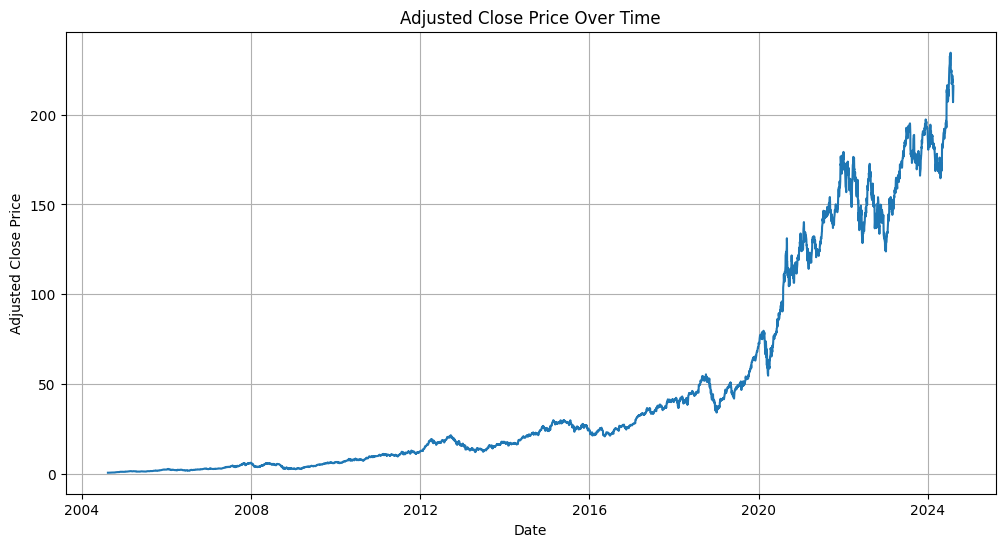

In [25]:
import matplotlib.pyplot as plt

# Assuming 'company_data' is your DataFrame containing the stock data
plt.figure(figsize=(12, 6))
plt.plot(company_data.index, company_data['Adj Close'])
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Adjusted Close Price Over Time')
plt.grid(True)
plt.show()

In [82]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define the Technology sector tickers (example list)
tech_tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'NVDA', 'META', 'INTC', 'AMD', 'CSCO', 'ORCL', 'IBM'
    # Add more tickers as needed
]

sector_index_ticker = 'XLC'  # Example sector index ticker for Technology

def fetch_data(tickers, start_date, end_date):
    data = {}
    for ticker in tickers:
        data[ticker] = yf.download(ticker, start=start_date, end=end_date)
    return data

def fetch_company_info(ticker):
    company = yf.Ticker(ticker)
    return company.info

# Fetch historical data
data = fetch_data(tech_tickers, '2004-08-12', '2024-08-12')
sector_index_data = yf.download(sector_index_ticker, start='2004-08-12', end='2024-08-12')

def calculate_metrics(info):
    metrics = {
        'P/E Ratio': info.get('forwardEps') / info.get('previousClose') if info.get('forwardEps') and info.get('previousClose') else None,
        'P/B Ratio': info.get('priceToBook'),
        'Dividend Yield': info.get('dividendYield'),
        'Dividend Payout Ratio': info.get('payoutRatio'),
        'ROE': info.get('returnOnEquity'),
        'ROA': info.get('returnOnAssets'),
        'Beta': info.get('beta'),
        'Market Capitalization': info.get('marketCap'),
        'Revenue Growth': info.get('revenueGrowth'),
        'Debt-to-Equity Ratio': info.get('debtToEquity'),
        'Free Cash Flow': info.get('freeCashflow'),
        'Current Ratio': info.get('currentRatio'),
        'Quick Ratio': info.get('quickRatio'),
        'PEG Ratio': info.get('pegRatio'),
        'Standard Deviation': None,
        'Value at Risk (VaR)': None,
        'Sharpe Ratio': None,
        'Sortino Ratio': None,
        'Maximum Drawdown': None,
        'Downside Deviation': None,
        'Tracking Error': None,
        'R-squared': None,
        'Treynor Ratio': None,
        'Information Ratio': None,
        'Conditional Value at Risk (CVaR)': None,
        'Beta-adjusted Sharpe Ratio': None,
        'Drawdown Duration': None,
        'Ulcer Index': None,
        'Jensen’s Alpha': None
    }
    return metrics

def calculate_standard_deviation(price_data):
    returns = price_data['Adj Close'].pct_change().dropna()
    return returns.std()

def calculate_var(price_data, confidence_level=0.95):
    returns = price_data['Adj Close'].pct_change().dropna()
    return returns.quantile(1 - confidence_level)

def calculate_sharpe_ratio(price_data, risk_free_rate=0.01):
    returns = price_data['Adj Close'].pct_change().dropna()
    excess_returns = returns - risk_free_rate / 252
    return excess_returns.mean() / excess_returns.std()

def calculate_sortino_ratio(price_data, risk_free_rate=0.01):
    returns = price_data['Adj Close'].pct_change().dropna()
    excess_returns = returns - risk_free_rate / 252
    downside_returns = excess_returns[excess_returns < 0]
    return excess_returns.mean() / downside_returns.std()

def calculate_max_drawdown(price_data):
    rolling_max = price_data['Adj Close'].cummax()
    drawdowns = (price_data['Adj Close'] - rolling_max) / rolling_max
    return drawdowns.min()

def calculate_downside_deviation(price_data, risk_free_rate=0.01):
    returns = price_data['Adj Close'].pct_change().dropna()
    downside_returns = returns[returns < risk_free_rate / 252]
    return downside_returns.std()

def calculate_tracking_error(company_data, index_data):
    common_dates = company_data.index.intersection(index_data.index)
    company_returns = company_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    index_returns = index_data.loc[common_dates, 'Adj Close'].pct_change().dropna()

    if len(company_returns) == 0 or len(index_returns) == 0:
        raise ValueError("No overlapping data points found.")

    aligned_data = pd.concat([company_returns, index_returns], axis=1).dropna()
    company_returns_aligned = aligned_data.iloc[:, 0]
    index_returns_aligned = aligned_data.iloc[:, 1]

    excess_returns = company_returns_aligned - index_returns_aligned
    return excess_returns.std()

def calculate_r_squared(company_data, index_data):
    common_dates = company_data.index.intersection(index_data.index)
    company_returns = company_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    index_returns = index_data.loc[common_dates, 'Adj Close'].pct_change().dropna()

    if len(company_returns) == 0 or len(index_returns) == 0:
        raise ValueError("No overlapping data points found.")

    aligned_data = pd.concat([company_returns, index_returns], axis=1).dropna()
    company_returns_aligned = aligned_data.iloc[:, 0]
    index_returns_aligned = aligned_data.iloc[:, 1]

    model = LinearRegression().fit(index_returns_aligned.values.reshape(-1, 1), company_returns_aligned.values)
    return model.score(index_returns_aligned.values.reshape(-1, 1), company_returns_aligned.values)

def calculate_treynor_ratio(price_data, risk_free_rate=0.01, beta=None):
    returns = price_data['Adj Close'].pct_change().dropna()
    excess_returns = returns.mean() - risk_free_rate / 252
    return excess_returns / beta if beta else None

def calculate_information_ratio(price_data, index_data):
    common_dates = price_data.index.intersection(index_data.index)
    company_returns = price_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    index_returns = index_data.loc[common_dates, 'Adj Close'].pct_change().dropna()

    if len(company_returns) == 0 or len(index_returns) == 0:
        raise ValueError("No overlapping data points found.")

    aligned_data = pd.concat([company_returns, index_returns], axis=1).dropna()
    company_returns_aligned = aligned_data.iloc[:, 0]
    index_returns_aligned = aligned_data.iloc[:, 1]

    excess_returns = company_returns_aligned - index_returns_aligned
    return excess_returns.mean() / excess_returns.std()

def calculate_cvar(price_data, confidence_level=0.95):
    returns = price_data['Adj Close'].pct_change().dropna()
    var = returns.quantile(1 - confidence_level)
    cvar = returns[returns <= var].mean()
    return cvar

def calculate_beta(company_data, index_data):
    common_dates = company_data.index.intersection(index_data.index)
    company_returns = company_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    index_returns = index_data.loc[common_dates, 'Adj Close'].pct_change().dropna()

    if len(company_returns) == 0 or len(index_returns) == 0:
        raise ValueError("No overlapping data points found.")

    aligned_data = pd.concat([company_returns, index_returns], axis=1).dropna()
    company_returns_aligned = aligned_data.iloc[:, 0]
    index_returns_aligned = aligned_data.iloc[:, 1]

    covariance_matrix = np.cov(company_returns_aligned, index_returns_aligned)
    beta = covariance_matrix[0, 1] / covariance_matrix[1, 1]
    return beta

def calculate_beta_adjusted_sharpe_ratio(price_data, index_data, risk_free_rate=0.01):
    beta = calculate_beta(price_data, index_data)
    sharpe_ratio = calculate_sharpe_ratio(price_data, risk_free_rate)
    return sharpe_ratio / beta if beta else None

def calculate_drawdown_duration(price_data):
    rolling_max = price_data['Adj Close'].cummax()
    drawdowns = (price_data['Adj Close'] - rolling_max) / rolling_max
    drawdown_duration = (drawdowns < 0).astype(int).groupby((drawdowns >= 0).astype(int).cumsum()).cumsum().max()
    return drawdown_duration

def calculate_ulcer_index(price_data):
    rolling_max = price_data['Adj Close'].cummax()
    drawdowns = (price_data['Adj Close'] - rolling_max) / rolling_max
    return np.sqrt((drawdowns**2).mean())

def calculate_jensens_alpha(company_data, index_data, risk_free_rate=0.01):
    common_dates = company_data.index.intersection(index_data.index)
    company_returns = company_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    index_returns = index_data.loc[common_dates, 'Adj Close'].pct_change().dropna()

    if len(company_returns) == 0 or len(index_returns) == 0:
        raise ValueError("No overlapping data points found.")

    aligned_data = pd.concat([company_returns, index_returns], axis=1).dropna()
    company_returns_aligned = aligned_data.iloc[:, 0]
    index_returns_aligned = aligned_data.iloc[:, 1]

    model = LinearRegression().fit(index_returns_aligned.values.reshape(-1, 1), company_returns_aligned.values)
    alpha = company_returns_aligned.mean() - (risk_free_rate / 252) - model.coef_[0] * index_returns_aligned.mean()
    return alpha

# Calculate metrics for each company
results = []
for ticker in tech_tickers:
    company_data = data[ticker]
    company_info = fetch_company_info(ticker)

    metrics = calculate_metrics(company_info)

    try:
        metrics['Standard Deviation'] = calculate_standard_deviation(company_data)
        metrics['Value at Risk (VaR)'] = calculate_var(company_data)
        metrics['Sharpe Ratio'] = calculate_sharpe_ratio(company_data)
        metrics['Sortino Ratio'] = calculate_sortino_ratio(company_data)
        metrics['Maximum Drawdown'] = calculate_max_drawdown(company_data)
        metrics['Downside Deviation'] = calculate_downside_deviation(company_data)
        metrics['Tracking Error'] = calculate_tracking_error(company_data, sector_index_data)
        metrics['R-squared'] = calculate_r_squared(company_data, sector_index_data)
        metrics['Treynor Ratio'] = calculate_treynor_ratio(company_data, beta=calculate_beta(company_data, sector_index_data))
        metrics['Information Ratio'] = calculate_information_ratio(company_data, sector_index_data)
        metrics['Conditional Value at Risk (CVaR)'] = calculate_cvar(company_data)
        metrics['Beta-adjusted Sharpe Ratio'] = calculate_beta_adjusted_sharpe_ratio(company_data, sector_index_data)
        metrics['Drawdown Duration'] = calculate_drawdown_duration(company_data)
        metrics['Ulcer Index'] = calculate_ulcer_index(company_data)
        metrics['Jensen’s Alpha'] = calculate_jensens_alpha(company_data, sector_index_data)
    except Exception as e:
        print(f"Error processing {ticker}: {e}")
        continue

    metrics['AdjustedClose'] = company_data['Adj Close'].iloc[-1]  # Use the latest adjusted close price
    results.append(metrics)

# Convert results to DataFrame
df = pd.DataFrame(results)

# Drop rows with NaN values (if any)
df = df.dropna()

# Split into features (X) and target (y)
X = df.drop(columns=['AdjustedClose'])
y = df['AdjustedClose']

# Check for NaNs in your features and target
print("Number of NaNs in X:", X.isna().sum().sum())
print("Number of NaNs in y:", y.isna().sum())

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Initialize ANN model
# model = Sequential()
# model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(16, activation='relu'))
# model.add(Dense(8, activation='relu'))
# model.add(Dense(1, activation='linear'))

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Train the model
# history = model.fit(X_train, y_train, epochs=20, verbose=1, validation_data=(X_test, y_test))

# # Evaluate the model
# loss = model.evaluate(X_test, y_test)
# print(f"Test Loss: {loss}")

# # Make predictions
# predictions = model.predict(X_test)

# # Calculate metrics
# mse = mean_squared_error(y_test, predictions)
# mae = mean_absolute_error(y_test, predictions)

# print(f"Mean Squared Error: {mse}")
# print(f"Mean Absolute Error: {mae}")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Number of NaNs in X: 0
Number of NaNs in y: 0
